In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN


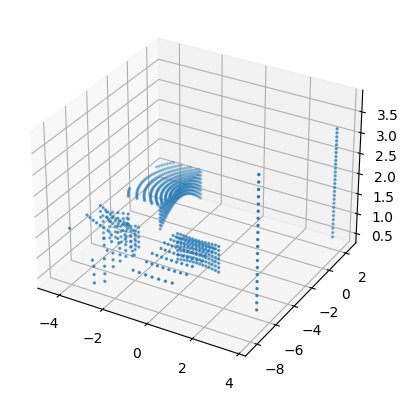

In [74]:
file = '_out/lidar/01516050.ply'

# Load data
data = np.loadtxt(file, skiprows=7)

# Transform Z axis (LIDAR is 2.5m above ground)
data[:,2] = 2.5 - data[:,2]

# Decimate data
data = data[::1]

# Filter data (ground removal)
data = data[data[:,2] > 0.5]

# Plot data
ax = plt.axes(projection='3d')
ax.scatter(-data[:,0], data[:,1], data[:,2], s=2)
plt.show()


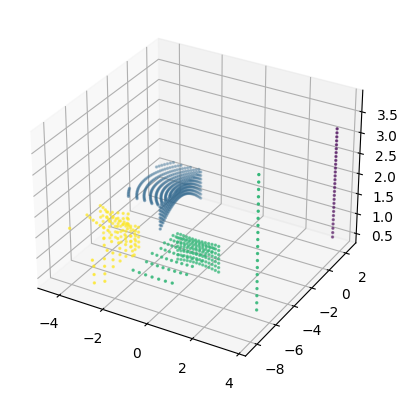

In [91]:
km = KMeans(n_clusters=4)
km.fit(data)

# Plot data
ax = plt.axes(projection='3d')
ax.scatter(-data[:,0], data[:,1], data[:,2], c=km.labels_, s=2)
plt.show()


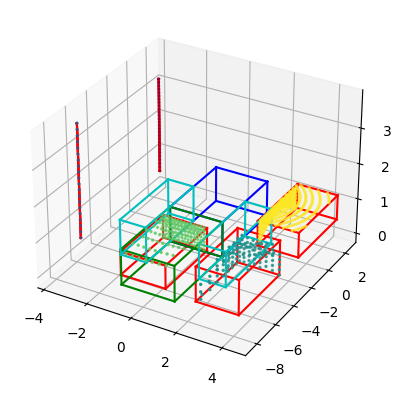

In [197]:
db = DBSCAN(eps=1.5, min_samples=10)
db.fit(data)

labeled_data = np.hstack((data, db.labels_.reshape(-1,1)))
labeled_data = labeled_data[labeled_data[:, -1].argsort()]
labeled_data = np.split(labeled_data[:,:-1], np.unique(labeled_data[:, -1], return_index=True)[1][1:])

ax = plt.axes(projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2], c=db.labels_, s=2)

objects = []

# Compute bounding box for each cluster
for cluster in labeled_data:
    x_min = np.min(cluster[:,0])
    y_min = np.min(cluster[:,1])
    z_min = np.min(cluster[:,2])

    x_max = np.max(cluster[:,0])
    y_max = np.max(cluster[:,1])
    z_max = np.max(cluster[:,2])

    objects.append([x_min, y_min, z_min, x_max, y_max, z_max, 'r'])

def render(x_min, y_min, z_min, x_max, y_max, z_max, c):
    # Plot bounding box
    ax.plot([x_min, x_min], [y_min, y_min], [z_min, z_max], c=c)
    ax.plot([x_min, x_min], [y_max, y_max], [z_min, z_max], c=c)
    ax.plot([x_max, x_max], [y_min, y_min], [z_min, z_max], c=c)
    ax.plot([x_max, x_max], [y_max, y_max], [z_min, z_max], c=c)

    ax.plot([x_min, x_max], [y_min, y_min], [z_min, z_min], c=c)
    ax.plot([x_min, x_max], [y_min, y_min], [z_max, z_max], c=c)
    ax.plot([x_min, x_max], [y_max, y_max], [z_min, z_min], c=c)
    ax.plot([x_min, x_max], [y_max, y_max], [z_max, z_max], c=c)

    ax.plot([x_min, x_min], [y_min, y_max], [z_min, z_min], c=c)
    ax.plot([x_min, x_min], [y_min, y_max], [z_max, z_max], c=c)
    ax.plot([x_max, x_max], [y_min, y_max], [z_min, z_min], c=c)
    ax.plot([x_max, x_max], [y_min, y_max], [z_max, z_max], c=c)

for x_min, y_min, z_min, x_max, y_max, z_max, c in objects:
    render(x_min, y_min, z_min, x_max, y_max, z_max, c)

collision_boxes = [
    [-1.2, -2.5, 0.0, 1.2, 2.5, 1.0, 'b'], # car
    [-1.2, -7.5, 0.0, 1.2, -2.5, 1.0, 'g'], # front bounding box
    [-1.2, -5, 0.0, -2.4, 0, 1.0, 'c'], # left bounding box
    [1.2, -5, 0.0, 2.4, 0, 1.0, 'c'], # right bounding box
]

for x_min, y_min, z_min, x_max, y_max, z_max, c in collision_boxes:
    render(x_min, y_min, z_min, x_max, y_max, z_max, c)

# Plot data
plt.show()


In [213]:
# Check front collisions
for i, (x_min_front, y_min_front, z_min_front, x_max_front, y_max_front, z_max_front, c) in enumerate(collision_boxes):
    print(i)
    for x_min, y_min, z_min, x_max, y_max, z_max, c in objects:
        centroid = [(x_min + x_max) / 2, (y_min + y_max) / 2, (z_min + z_max) / 2]

        if x_max_front >= x_min and x_min_front <= x_max and y_max_front >= y_min and y_min_front <= y_max and z_max_front >= z_min and z_min_front <= z_max:
            print(f'collision with {i} object at {centroid[0], centroid[1], centroid[2]}')


0
1
collision with 1 object at (0.09769999999999995, -6.0355, 0.8324)
2
3
